In [ ]:
# !pip install snowflake --user
# !pip install snowflake-connector-python --user
# # !pip install matplotlib
# # !pip install seaborn
# !pip install xgboost

# Data

In [1]:
import os
import sys
import logging
import boto3
import itertools as it
import io
from utils import *
import snowflake.connector

In [2]:
from matplotlib.pyplot import figure

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import GroupKFold

In [5]:
import datetime

In [6]:
from datetime import timedelta

In [7]:
import scipy.stats as st

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt


In [9]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

In [10]:
class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

In [11]:
def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

In [12]:
logger = logging.getLogger()
logger.info(f'Loading inputs')
data_list =[]

s3 = boto3.resource('s3')
bucket = s3.Bucket('hbo-ingest-datascience-content-dev')

In [13]:
for obj in bucket.objects.filter(Prefix='input_percent_view'):
    key = obj.key
    logger.info('Loading csv file {}'.format(key))
    body = obj.get()['Body']
    var_name = key.split('.')[0].split('/')[1]
    print('Reading {0} features'.format(var_name))
    exec("{0}=pd.read_csv(body, na_values = [r'\\\\N'])".format(var_name))
    exec("{0}.columns = {0}.columns.str.lower()".format(var_name))
    
    # exclude the full null columns
    exec("{0} = {0}.loc[:,{0}.isnull().sum()!={0}.shape[0]]".format(var_name))

    # exclude the old Mortal Kombat movie because the trailer percent view 
    # matching matches the trailer of the new movie to the old movie
    # exclude Tom & Jerry due to unresolvable data issue
    exec("{0} = {0}.loc[{0}['match_id_platform'].\
        isin(['1-GYGQBcwsaCIW2XgEAAAAL', '0-GYGQBcwsaCIW2XgEAAAAL', '1-GYEb9QwLgFF9_ZwEAAAA7', '0-GYEb9QwLgFF9_ZwEAAAA7'])==False,:]\
        .reset_index(drop = True)".format(var_name))
    
    # append the feature df
    exec("data_list.append({0})".format(var_name))

Reading funnel_metric_feature features
Reading media_cost_postlaunch_feature features
Reading media_cost_prelaunch_feature features
Reading metadata_feature features
Reading prelaunch_trailer_feature features
Reading prelaunch_trailer_feature_before28 features
Reading sub_total_feature features
Reading trailer_feature features
Reading vtp_feature features
Reading wiki_view_feature_before28 features
Reading wiki_view_post_feature features
Reading wiki_view_pre_feature features


In [14]:
for obj in bucket.objects.filter(Prefix='psi_first_views/fv_pred_munged_2022'):
    key = obj.key
    logger.info('Loading csv file {}'.format(key))
    body = obj.get()['Body']
    var_name = key.split('.')[0].split('/')[-1]  
    print (var_name)
    fv_pre = pd.read_csv(body, na_values = [r'\\\\N'])

fv_pred_munged_2022-03-22


In [15]:
for obj in bucket.objects.filter(Prefix='psi_first_views/fv_train_munged_2022-03'):
    key = obj.key
    logger.info('Loading csv file {}'.format(key))
    body = obj.get()['Body']
    var_name = key.split('.')[0].split('/')[-1]   
    print (var_name)
    fv_train = pd.read_csv(body, na_values = [r'\\\\N'])

fv_train_munged_2022-03-22


In [16]:
fv_train = fv_train.drop_duplicates()

In [17]:
popcorn_titles=fv_train[fv_train['category'] == 'Popcorn'].title_id.unique()

In [18]:
fv_train =fv_train[(fv_train['category']!='Pay1')
                  |((fv_train['category']=='Pay1') & ~(fv_train['title_id'].isin(popcorn_titles)))]

In [19]:
# retail_first_views = run_query('''
# select title_name, paying_first_views_7 as retail_first_views_7,title_id, season_number,
# case when content_category = 'movies' then title_id 
# else concat(title_id, '-', to_char(to_number(season_number)) ) end as match_id
# from max_dev.workspace.forecasting_fv_summary 
# where country_iso_code = 'US'
# ''')

In [20]:
# retail_first_views=retail_first_views[['title_name', 'match_id', 'retail_first_views_7']]

In [21]:
view_data=run_query('''
select match_id, DAYS_ON_HBO_MAX as DAYS_SINCE_FIRST_OFFERED, 
PCT_ACTIVES as RETAIL_VIEWED_COUNT_PERCENT
from max_dev.workspace.pct_actives_metric_values_pipeline 
where DAYS_ON_HBO_MAX = 28
''')

In [22]:
metadata_feature = fv_train[['title_name', 'tier', 'content_category', 'category', 'title_id', 'season_number', 'effective_start_date', 'prequel_count',
                            'prequel_featured_count']]

In [23]:
metadata_feature['match_id'] = metadata_feature['title_id']
metadata_feature.loc[metadata_feature['content_category'] == 'series', 'match_id'] = \
                metadata_feature['title_id'] + '-' +metadata_feature['season_number'].astype(int).astype(str)

In [24]:
metadata_feature=metadata_feature[['title_name', 'match_id', 'title_id', 'tier', 'category', 'season_number', 'effective_start_date', 'prequel_count', 'prequel_featured_count']]

In [25]:
# data = pd.merge(retail_first_views, view_data, on = 'match_id')
data = pd.merge(view_data, metadata_feature, on = 'match_id')

In [27]:
media_spent_2021 = run_query('''
SELECT LOB, PREMIERE, CAMPAIGN, TIER, '$0' AS PREV_YEAR_BUDGET, CURRENT_YEAR_BUDGET,
W1, W2, W3, W4, W5, W6, W7, W8, W9, W10, W11, W12, W13, W14, W15, W16, W17, W18, W19, W20, W21, W22, W23, W24, W25, W26, W27, W28, W29, 
W30, W31, W32, W33, W34, W35, W36, W37, W38, W39, W40, W41, W42, W43, W44, W45, W46, W47, W48, W49, W50, W51, W52, W53
FROM "MAX_DEV"."WORKSPACE"."HBOMAX_CONTENT_SPEND_2021"
''')

media_spent_2022 = run_query('''
SELECT LOB, $2 as PREMIERE, $3 as CAMPAIGN, $9 as TIER, $10 as PREV_YEAR_BUDGET, $6 as CURRENT_YEAR_BUDGET,
W1, W2, W3, W4, W5, W6, W7, W8, W9, W10, W11, W12, W13, W14, W15, W16, W17, W18, W19, W20, W21, W22, W23, W24, W25, W26, W27, W28, W29, 
W30, W31, W32, W33, W34, W35, W36, W37, W38, W39, W40, W41, W42, W43, W44, W45, W46, W47, W48, W49, W50, W51, W52, W53
FROM "MAX_DEV"."CKG"."HBOMAX_CONTENT_SPEND"
''')

In [28]:
media_spent_2021['premiere']=pd.to_datetime(media_spent_2021['premiere'], errors='coerce')
media_spent_2021['premiere']=media_spent_2021['premiere'].dt.strftime('%Y-%m-%d')
media_spent_2021=media_spent_2021[media_spent_2021['campaign'].notnull()]

media_spent_2022['premiere']=pd.to_datetime(media_spent_2022['premiere'], errors='coerce')
media_spent_2022['premiere']=media_spent_2022['premiere'].dt.strftime('%Y-%m-%d')
media_spent_2022=media_spent_2022[media_spent_2022['campaign'].notnull()]

In [29]:
daterange=[]
start = datetime.date(2021,1,4)
for week in range(0, 52):
    date = (start + datetime.timedelta(weeks = week)).isoformat()
    daterange.append(date)
    
media_spent_2021.columns = ['lob', 'premiere', 'campaign', 'tier', 'prev_year_budget','current_year_budget'] + daterange + ['2022-01-01']

media_spent_2021 = media_spent_2021.melt(id_vars = ['lob', 'premiere', 'campaign', 'tier', 'prev_year_budget', 'current_year_budget', ],
                var_name='start_date',
                value_name = 'spent')

media_spent_2021['end_date'] = (pd.to_datetime(media_spent_2021['start_date']) + datetime.timedelta(days = 6)).dt.strftime('%Y-%m-%d')
media_spent_2021.loc[media_spent_2021['start_date'] == '2022-01-01', 'end_date'] = '2022-01-02'
media_spent_2021.loc[media_spent_2021['start_date'] == '2021-12-27', 'end_date'] = '2021-12-31'

In [30]:
daterange=[]
start = datetime.date(2022,1,3)
for week in range(0, 52):
    date = (start + datetime.timedelta(weeks = week)).isoformat()
    daterange.append(date)

media_spent_2022.columns = ['lob', 'premiere', 'campaign', 'tier', 'prev_year_budget','current_year_budget', '2022-01-01']\
                            + daterange

media_spent_2022 = media_spent_2022.melt(id_vars = ['lob', 'premiere', 'campaign', 'tier', 'prev_year_budget', 'current_year_budget', ],
                var_name='start_date',
                value_name = 'spent')

media_spent_2022['end_date'] = (pd.to_datetime(media_spent_2022['start_date']) + datetime.timedelta(days = 6)).dt.strftime('%Y-%m-%d')
media_spent_2022.loc[media_spent_2022['start_date'] == '2022-01-01', 'end_date'] = '2022-01-02'

In [31]:
# media_spent = pd.concat([media_spent_2021, media_spent_2022], axis = 0)
media_spent=media_spent_2021

In [32]:
media_spent['spent'] = media_spent['spent'].str.replace('[\$,-]', '', regex=True)
media_spent['spent'] = pd.to_numeric(media_spent['spent'], errors='coerce')
media_spent['spent'] = media_spent['spent'].fillna(0)

media_spent['current_year_budget'] = media_spent['current_year_budget'].str.replace('[\$,-]', '', regex=True)
media_spent['current_year_budget'] = pd.to_numeric(media_spent['current_year_budget'], errors='coerce')
media_spent['current_year_budget'] = media_spent['current_year_budget'].fillna(0)

media_spent['prev_year_budget'] = media_spent['prev_year_budget'].str.replace('[\$,-]', '', regex=True)
media_spent['prev_year_budget'] = pd.to_numeric(media_spent['prev_year_budget'], errors='coerce')
media_spent['prev_year_budget'] = media_spent['prev_year_budget'].fillna(0)

In [33]:
media_spent=media_spent.groupby(['lob', 'premiere', 'campaign', 'tier', 'start_date', 'end_date']).max().reset_index()

In [34]:
media_spent[(media_spent['start_date']=='2022-01-01') & (media_spent['spent']>0)]

,lob,premiere,campaign,tier,start_date,end_date,prev_year_budget,current_year_budget,spent
6200,Max Originals,2022-01-01,Harry Potter 20th Anniversary: Return to Hogwarts,A,2022-01-01,2022-01-02,0,7810943.0,3033488.0


In [35]:
ignored_titles = ['30 Coins (MCM Budget)', 'Real Time Bill Maher',
               'Euphoria Special Episode', 'Painting with John Lurie Series',
               'Black Art', 'Crime of The Century', 'Sam Jay', 'NYC Epicenters',
               'Curb Your Enthusiasm S11', 'God Save Texas',
               'Drew Michael Special', 'Real Time Bill Maher S20', "It's a Sin", 'Wahl Street',
               'Big Shot with Bethenny', 'Lucy and the Human Chimp', 'Starstruck',
               'Boondocks S5', '10 Year Old Tom',
               'The Way Down: God, Greed and the Cult of Gwen Shamblin',
               '15 Minutes of Shame']

In [36]:
name_dict = {'Lady & The Dale':'The Lady and the Dale',
        'Last Week Tonight':'Last Week Tonight with John Oliver',
        'Allen v. Farrow (fka Project Eliza)' : 'Allen v. Farrow',
        'Q: Into the Storm (fka Project 17)':'Q: Into the Storm',
        'Tina Turner':'Tina',
        'Exterminate The Brutes':'Exterminate All the Brutes',
        'A Black Lady Sketch':'A Black Lady Sketch Show',
        'The Shop':'The Shop: Uninterrupted',
        'Catch & Kill':'Catch and Kill: The Podcast Tapes',
        'Tig Notaro Special':'Tig Notaro: Drawn',
        'Costas':'Back On the Record with Bob Costas',
        'Small Town News':'Small Town News: KPVM Pahrump',
        'Hard Knocks':'Hard Knocks: Los Angeles',
        'Hard Knocks: Colts':'Hard Knocks In Season: The Indianapolis Colts', 
        'Ricky Velez Special':"Ricky Velez: Here's Everything",
        'Curb Your Enthusiasm':'Curb Your Enthusiasm',
        'Black & Missing' : 'Black and Missing',
        'Rock and Roll Hall of Fame':'2021 Rock and Roll Hall of Fame Induction Ceremony',
        'That Damn Michael Che Show (Community Service)':'That Damn Michael Che',
        'Street Gang':'Street Gang: How We Got to Sesame Street',
        'Righteous Gemstones S2':'The Righteous Gemstones',
        'Winning Time':'Winning Time: The Rise of the Lakers Dynasty',
        'Little Things':'The Little Things',
        'Generation 1A': 'Genera+ion',
        'Generation 1B': 'Genera+ion',
        'Snyder Cut':"Zack Snyder's Justice League",
        'Great Pottery Throw Down S4':'The Great Pottery Throw Down',
        'Friends Reunion Special':'Friends: The Reunion',
        'Gossip Girl 1A':'Gossip Girl',
        'Gossip Girl 1B':'Gossip Girl',
        'Hallowed Ground':'Eyes on the Prize: Hallowed Ground',
        'You Know What It Is (Marlon Wayans Comedy)':'Marlon Wayans: You Know What It Is',
        'Many Saints of Newark':'The Many Saints of Newark',
        'Sex Lives of College Girls':'The Sex Lives of College Girls',
        'Santa, Inc':'Santa Inc.',
        'And Just Like That':'And Just Like That...',
        'Euphoria Special Episode':'Euphoria Special Episode Part 2: Jules',
       }

In [37]:
media_spent=media_spent.replace({"campaign": name_dict})
media_spent=media_spent[~media_spent['campaign'].isin(ignored_titles)]
media_spent['title_upper']=media_spent['campaign'].str.upper()
media_spent['title_upper']=media_spent['title_upper'].str.strip(' ')
media_spent.loc[media_spent['campaign'].str[-2::1].str.contains('S'), 'title_upper'] = media_spent['title_upper'].str[:-3:1]

In [38]:
media_spent_budget = media_spent[['title_upper', 'current_year_budget']].drop_duplicates()

In [39]:
data['title_upper']=data['title_name'].str.upper()

In [40]:
data = pd.merge(data, media_spent_budget, on = ['title_upper'], how = 'left')

In [27]:
data.head()

,match_id,days_since_first_offered,retail_viewed_count,total_retail_sub_count,retail_viewed_count_percent,title_name,title_id,tier,category,season_number,effective_start_date,prequel_count,prequel_featured_count
0,GYEo27wV1b5O1wwEAAAAC-1,28,375481,12445272,0.030171,Exterminate All the Brutes,GYEo27wV1b5O1wwEAAAAC,3,Docu-Series,1,2021-04-08,-1.0,-1.0
1,GXRuC4gJdpm2YwgEAAAF_-2,28,1275005,16201126,0.078699,The Righteous Gemstones,GXRuC4gJdpm2YwgEAAAF_,2,Scripted Comedy Series,2,2022-01-10,-1.0,-1.0
2,GVU2cJww-hI7DwvwIAT5u-4,28,103865,13283343,0.007819,In Treatment,GVU2cJww-hI7DwvwIAT5u,3,Scripted Drama Series,4,2021-05-24,-1.0,-1.0
3,GX68GDw1CD8LDJwEAAAAG,28,737143,8343264,0.088352,The King of Staten Island,GX68GDw1CD8LDJwEAAAAG,2,Pay1,0,2021-01-10,0.0,0.0
4,GYcHzowhh6MPCJwEAAAAC-1,28,159854,16295625,0.009810,"My Mom, Your Dad",GYcHzowhh6MPCJwEAAAAC,3,Unscripted Series,1,2022-01-13,-1.0,-1.0


## 2022 titles

In [106]:
fv_train.head()

,Unnamed: 0,tier,content_category,category,title_name,title_id,season_number,effective_start_date,prequel_count,prequel_featured_count,first_views,first_views_log,tier_adj,title_upper
0,134,3,series,Unscripted Series,House of Ho,GXvTTlQwJdcLDGQEAAAMj,1,2020-12-10,-1.0,-1.0,28355,10.252559,3,HOUSE OF HO
1,331,3,series,Unscripted Series,The Great Pottery Throw Down,GX0gQ9AKAgr5cuAEAAAG_,2,2020-09-17,-1.0,-1.0,631,6.447306,3,THE GREAT POTTERY THROW DOWN
2,104,3,series,Unscripted Series,Full Bloom,GX6BA9wumwpbDwgEAAAA4,2,2021-06-10,-1.0,-1.0,1160,7.056175,3,FULL BLOOM
3,333,3,series,Unscripted Series,The Great Pottery Throw Down,GX0gQ9AKAgr5cuAEAAAG_,4,2021-04-01,-1.0,-1.0,1948,7.574558,3,THE GREAT POTTERY THROW DOWN
4,310,3,series,Unscripted Series,The Bridge,GYBMTBAxniqsjwwEAAAAR,1,2021-02-11,-1.0,-1.0,1637,7.400621,3,THE BRIDGE


In [108]:
media_spent_master = run_query('''
select campaign, imdb.ORIGINAL_TITLE as title_name , " IMDB_ID" as IMDB_ID, $7 as tier, " EXISTING_IP" as existing_ip, 
" TOTAL_ORIGINALS_BUDGET" as TOTAL_ORIGINALS_BUDGET, $9 SEASON, UPPER($12) AS UNIVERSAL_TITLE_NAME
FROM "MAX_DEV"."CKG"."HBOMAX_CONTENT_MASTER_LIST" ml
JOIN "ENTERPRISE_DATA"."CATALOG"."IMDB_TITLE" imdb
on ml.' IMDB_ID' = imdb.title_d
''')

ProgrammingError: 001003 (42000): SQL compilation error:
syntax error line 5 at position 0 unexpected 'on'.

In [264]:
media_spent_master.head()

,campaign,imdb_id,tier,existing_ip,total_originals_budget,season,universal_title_name
0,Harry Potter 20th Anniversary: Return to Hogwarts,tt16116174,A,None,"$11,810,943",N/A,HARRY POTTER 20TH ANNIVERSARY: RETURN TO HOGWARTS
1,Search Party S5,tt5460226,C,2,"$100,000",S5,SEARCH PARTY
2,Euphoria S2,tt8772296,A,3,"$11,360,000",S2,EUPHORIA
3,Righteous Gemstones S2,tt8634332,B,3,"$4,000,000",S2,THE RIGHTEOUS GEMSTONES
4,Peacemaker,tt13146488,A,1,"$20,275,000",S1,PEACEMAKER


# Correlation Plots

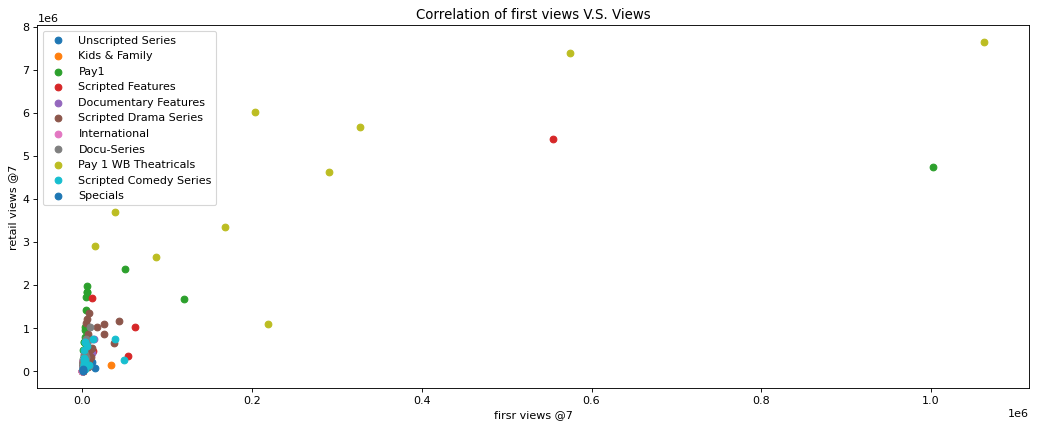

In [58]:
# SCatter of total views 
# plot_data = data[['retail_first_views_7', 'retail_viewed_count', 'category']]
figure(figsize=(16, 6), dpi=80)

for c in data.category.unique():
    plot_data = data[data['category'] == c]
    plt.scatter(plot_data['retail_first_views_7'], plot_data['retail_viewed_count'], label = c)
plt.title('Correlation of first views V.S. Views')
plt.xlabel('firsr views @7')
plt.ylabel('retail views @7')
plt.legend()
plt.show()

In [ ]:
# "Zack Snyder's Justice League", 'Mortal Kombat', 'Wonder Woman 1984', 'Godzilla vs. Kong'

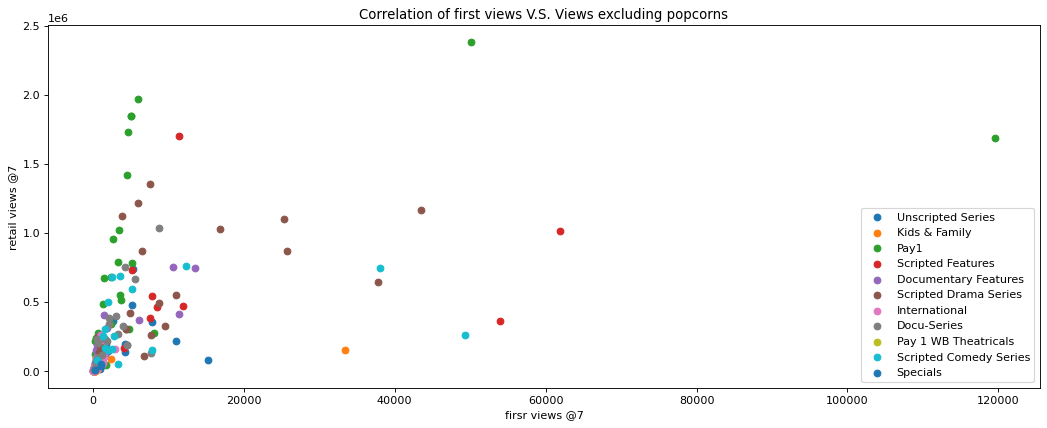

In [65]:
# SCatter of total views 
# plot_data = data[['retail_first_views_7', 'retail_viewed_count', 'category']]
figure(figsize=(16, 6), dpi=80)

for c in data.category.unique():
    plot_data = data[(data['category'] == c)
                    &~(data['title_name'].isin(["Zack Snyder's Justice League", 'Mortal Kombat', 'Wonder Woman 1984', 'Godzilla vs. Kong']))
                    &~(data['category'].isin(['Pay 1 WB Theatricals']))]
    plt.scatter(plot_data['retail_first_views_7'], plot_data['retail_viewed_count'], label = c)
plt.title('Correlation of first views V.S. Views excluding popcorns')
plt.xlabel('firsr views @7')
plt.ylabel('retail views @7')
plt.legend()
plt.show()

In [66]:
data=data.sort_values(by = ['tier'])

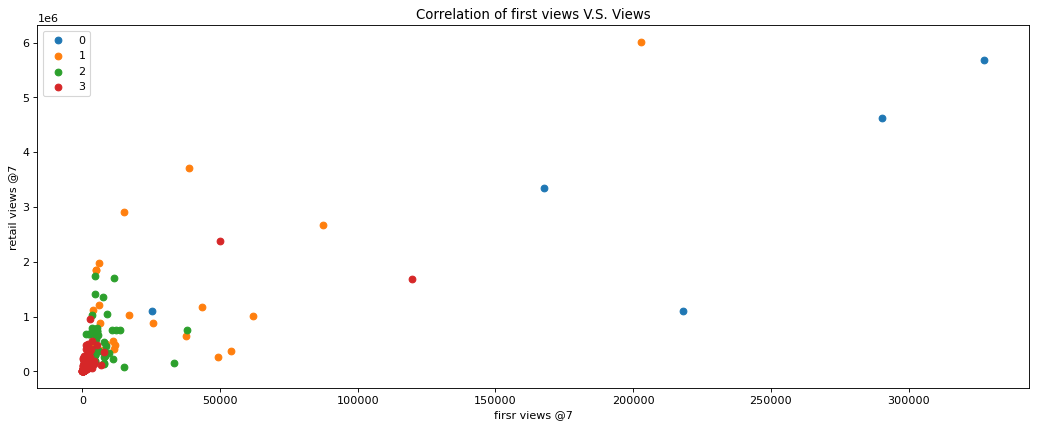

In [67]:
# SCatter of total views 
# plot_data = data[['retail_first_views_7', 'retail_viewed_count', 'category']]
figure(figsize=(16, 6), dpi=80)

for c in data.tier.unique():
    plot_data = data[(data['tier'] == c)
                    &~(data['title_name'].isin(["Zack Snyder's Justice League", 'Mortal Kombat', 'Wonder Woman 1984', 'Godzilla vs. Kong']))]
    plt.scatter(plot_data['retail_first_views_7'], plot_data['retail_viewed_count'], label = c)
plt.title('Correlation of first views V.S. Views')
plt.xlabel('firsr views @7')
plt.ylabel('retail views @7')
plt.legend()
plt.show()

In [137]:
data[data['retail_first_views_7']>150000].sort_values(by = ['retail_first_views_7'])

,title_name,match_id,retail_first_views_7,days_since_first_offered,retail_viewed_count,total_retail_sub_count,retail_viewed_count_percent,tier,category,season_number,effective_start_date,prequel_count,prequel_featured_count
27,The Little Things,GYA79hQZbUsI3gQEAAAB0,167507.0,28,3347097,8407793,0.398095,0,Pay 1 WB Theatricals,0,2021-01-29,0.0,0.0
147,Dune,GYUjdLgBiJp5otAEAAAAJ,202976.0,28,6014303,12919614,0.465517,1,Pay 1 WB Theatricals,0,2021-10-21,1.0,20.0
202,Tom & Jerry,GYEb9QwLgFF9_ZwEAAAA7,218131.0,28,1105964,9554805,0.115750,0,Pay 1 WB Theatricals,0,2021-02-26,0.0,0.0
79,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,290232.0,28,4617129,12859293,0.359050,0,Pay 1 WB Theatricals,0,2021-06-04,2.0,20.0
73,Space Jam: A New Legacy,GYOSUnARCGWWmcAEAAAAC,327511.0,28,5681878,12803067,0.443790,0,Pay 1 WB Theatricals,0,2021-07-16,1.0,20.0
112,Zack Snyder's Justice League,GYDAnZgCFQ8IJpQEAAAAN,554391.0,28,5400655,11370473,0.474972,0,Scripted Features,0,2021-03-18,2.0,20.0
93,Mortal Kombat,GYGYKfQwaKLheqwEAAAEC,574506.0,28,7389661,12541255,0.589228,0,Pay 1 WB Theatricals,0,2021-04-23,1.0,20.0
99,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,1002389.0,28,4738180,7970401,0.594472,1,Pay1,0,2021-05-13,1.0,20.0
43,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,1062891.0,28,7651044,12260883,0.624021,0,Pay 1 WB Theatricals,0,2021-03-31,5.0,20.0


In [42]:
plot_data = data[['tier', 'category', 'prequel_count', 'prequel_featured_count', 'retail_viewed_count', 'retail_viewed_count_percent',
                 'current_year_budget', 'season_number']]

In [43]:
plot_data.current_year_budget.unique()

array([  350000.,  1500000.,  2750000.,       nan,   174280.,  1000000.,
        7694346.,   100000.,   250000.,   800000.,   150000.,  5400000.,
         900000.,  3000000.,        0.,  1600000.,   972464.,  1498192.,
        4664459.,  1235541., 11000000.,  7810943.,  1752000.,   125000.,
         500000.,   210000.,   225000.,  6050000.,   400000.,  3800000.,
         115000.,  9528000., 13415686.,  5344714.,   320000.,  1481511.,
         145000.,   750000.,  2864555.,  2886900.,  9426603.,    92779.,
        2000000.,  1800000.,   275000.,  4170000.,   450000.,  3700000.,
        2500000.,   165000.,  8500000.,  1450000.,   310000.,  7113045.,
         200000., 19600000.,  2950000.,  8000000.,  6275000.,  2300000.])

In [44]:
category_onehot = pd.get_dummies(plot_data.category, prefix='category')
# category_onehot

In [45]:
plot_data=pd.concat([plot_data, category_onehot], axis = 1)

In [46]:
corr = plot_data.corr()[['retail_viewed_count_percent']]

In [47]:
mask=np.zeros_like(corr, dtype=np.bool)

In [50]:
corr.sort_values(by = ['retail_viewed_count_percent'])

,retail_viewed_count_percent
tier,-0.834761
category_International,-0.187126
category_Kids & Family,-0.142292
category_Unscripted Series,-0.135649
category_Documentary Features,-0.132324
season_number,-0.124017
category_Docu-Series,-0.069568
category_Specials,-0.069407
category_Scripted Comedy Series,-0.034045
category_Pay1,0.012576


<AxesSubplot:>

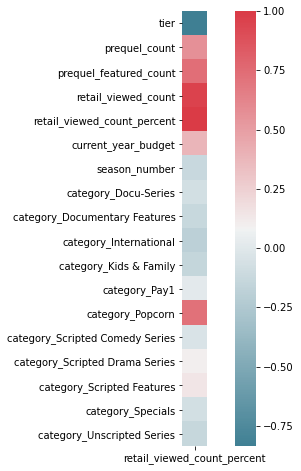

In [48]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

# Cross Validation

In [26]:
import xgboost  
from xgboost import XGBRegressor

In [27]:
train_data = data[['match_id', 'title_name', 'tier', 'category', 'season_number', 
                   #'current_year_budget',
                   'prequel_featured_count', 'retail_viewed_count_percent', 'effective_start_date']]
category_onehot = pd.get_dummies(train_data.category, prefix='category')
train_data=pd.concat([train_data, category_onehot], axis = 1)
train_data.drop_duplicates(inplace = True)

In [28]:
FEATURE_COLS = [ 'tier', 'prequel_featured_count', 'category_Docu-Series', 'category_Documentary Features','season_number', 
                #'current_year_budget',
       'category_International', 'category_Kids & Family', 'category_Pay1','category_Popcorn' , 'category_Scripted Comedy Series',
       'category_Scripted Drama Series', 'category_Scripted Features',
       'category_Specials', 'category_Unscripted Series']
TARGET_COL = ['retail_viewed_count_percent']

In [29]:
from sklearn.model_selection import KFold

In [97]:
n_title = len(train_data.match_id.unique())
kf = KFold(n_splits=n_title)

In [38]:
kf

KFold(n_splits=238, random_state=None, shuffle=False)

In [41]:
validation_set = pd.DataFrame()
feature_importances = pd.DataFrame()
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
for train_index, test_index in kf.split(train_data, groups=train_data['match_id'].values):
    train_df, test_df = train_data.iloc[train_index], train_data.iloc[test_index]
    # For pre-2019 titles, use all data as training set
    # For post-2019 titles, only use older titles as training set
    avail_date = test_df['effective_start_date'].values[0]
    train_df = train_df[(train_df['effective_start_date'] <= avail_date)]
    print ("Validation Title: " + test_df['title_name'].values[0])
    
    X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
    y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred = pd.DataFrame(pred)
    pred.columns = ['pred']
    test_df.reset_index(inplace = True, drop = True)
    test_df = pd.concat([test_df, pred], axis = 1)
    validation_set = pd.concat([validation_set, test_df], axis = 0)
      
    fi = model.feature_importances_
    fi_df = pd.DataFrame([fi])
    fi_df.columns = FEATURE_COLS
    fi_df['match_id'] = test_df['match_id'].values[0]
    fi_df['title_name'] = test_df['title_name'].values[0]
    feature_importances=pd.concat([feature_importances, fi_df], axis = 0)

Validation Title: Exterminate All the Brutes
Validation Title: In Treatment
Validation Title: My Mom, Your Dad
Validation Title: Wonder Woman 1984
Validation Title: The Lady and the Dale
Validation Title: Doom Patrol
Validation Title: Euphoria Special Episode Part 1: Rue
Validation Title: The Last Cruise


KeyboardInterrupt: 

In [ ]:
validation_set.to_csv('validation_set.csv')
feature_importances.to_csv('feature_importances.csv')

# Results

In [28]:
validation_set=pd.read_csv('validation_set.csv')
feature_importances = pd.read_csv('feature_importances.csv')

In [29]:
# Exclude some outliers
validation_set = validation_set[~(validation_set['match_id'].isin(['GYEb9QwLgFF9_ZwEAAAA7']))]

In [30]:
validation_set['mape'] = np.abs(validation_set['pred'] - validation_set['retail_viewed_count_percent'])/validation_set['retail_viewed_count_percent']
validation_set['mpe'] = (validation_set['pred'] - validation_set['retail_viewed_count_percent'])/validation_set['retail_viewed_count_percent']

In [31]:
validation_set.groupby(['category']).mape.mean()

category
Docu-Series               1.196362
Documentary Features      1.082419
International             9.763304
Kids & Family             6.009762
Pay1                      0.374409
Popcorn                   0.275298
Scripted Comedy Series    0.666880
Scripted Drama Series     0.594524
Scripted Features         0.453534
Specials                  1.290780
Unscripted Series         1.273885
Name: mape, dtype: float64

In [79]:
validation_set.groupby(['tier']).mape.mean()

tier
0    0.278992
1    0.346355
2    1.026811
3    3.425787
Name: mape, dtype: float64

In [113]:
validation_set[validation_set['mape'] > 100]

,Unnamed: 0,match_id,title_name,tier,category,season_number,prequel_featured_count,retail_viewed_count_percent,effective_start_date,category_Docu-Series,category_Documentary Features,category_International,category_Kids & Family,category_Pay 1 WB Theatricals,category_Pay1,category_Scripted Comedy Series,category_Scripted Drama Series,category_Scripted Features,category_Specials,category_Unscripted Series,pred,mape,mpe
10,0,GXl2MywUlhSLCHAEAAAiR-1,Entre hombres (Amongst Men),3,International,1,-1.0,0.000044,2021-09-30,0,0,1,0,0,0,0,0,0,0,0,0.009432,213.369955,213.369955


In [114]:
validation_set['effective_start_date']=pd.to_datetime(validation_set['effective_start_date'])

In [115]:
validation_set=validation_set[(validation_set['mape']<30)
                             &~(validation_set['category'].isin(['Kids & Family', 'International']))]

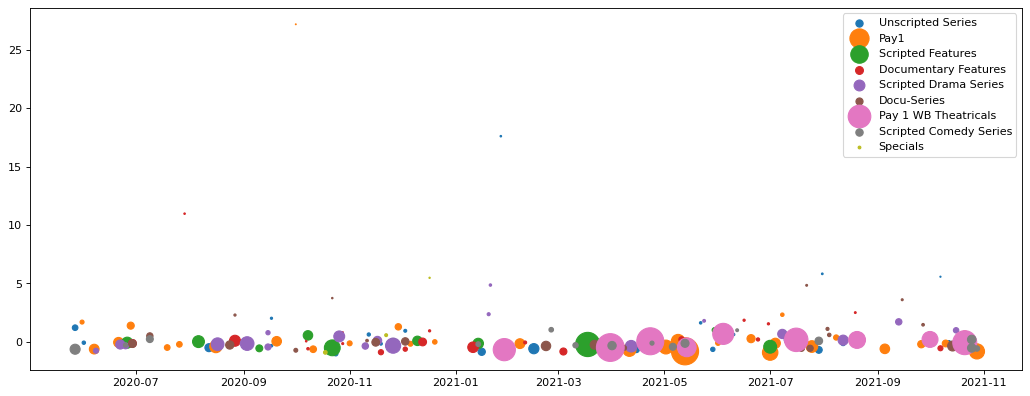

In [116]:
figure(figsize=(16, 6), dpi=80)
for c in validation_set.category.unique():
    plot_data = validation_set[validation_set['category'] == c]
    plt.scatter(plot_data['effective_start_date'], plot_data['mpe'], label = c, s = plot_data['retail_viewed_count_percent']*1000)
# plt.title('Correlation of first views V.S. Views')
# plt.xlabel('firsr views @7')
# plt.ylabel('retail views @7')
plt.legend()
plt.show()

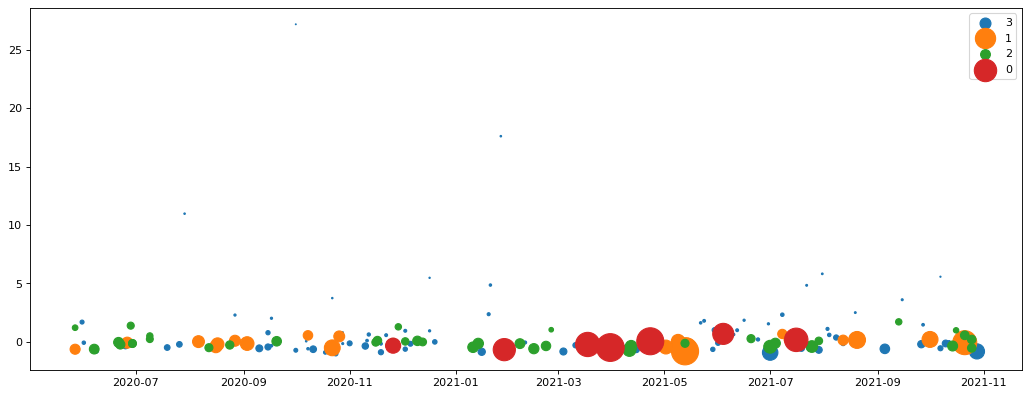

In [117]:
figure(figsize=(16, 6), dpi=80)
for c in validation_set.tier.unique():
    plot_data = validation_set[validation_set['tier'] == c]
    plt.scatter(plot_data['effective_start_date'], plot_data['mpe'], label = c, s = plot_data['retail_viewed_count_percent']*1000)
# plt.title('Correlation of first views V.S. Views')
# plt.xlabel('firsr views @7')
# plt.ylabel('retail views @7')
plt.legend()
plt.show()

# Predictions

In [41]:
prediction_titles = ['Hacks']

In [39]:
fv_pre[fv_pre['title_name'].str.contains('Hacks')]

,Unnamed: 0,prequel_featured_count,category,prequel_count,season_number,effective_start_date,tier,tier_adj,title_name,content_category,first_views_log_pred,first_views_pred,pred_date,decay_category
305,305,-1.0,Scripted Comedy Series,-1.0,1,2021-05-13,2,2,Hacks,series,9.924792,20430.666,2022-03-22,Scripted Comedy Series
306,306,-1.0,Scripted Comedy Series,-1.0,2,2022-05-19,2,2,Hacks,series,9.924792,20430.666,2022-03-22,Scripted Comedy Series
307,307,-1.0,Scripted Comedy Series,-1.0,3,2023-05-04,2,2,Hacks,series,9.924792,20430.666,2022-03-22,Scripted Comedy Series


In [40]:
train_data[train_data['title_name'].str.contains('Hacks')]

,match_id,title_name,tier,category,season_number,prequel_featured_count,retail_viewed_count_percent,effective_start_date,category_Docu-Series,category_Documentary Features,category_International,category_Kids & Family,category_Pay1,category_Popcorn,category_Scripted Comedy Series,category_Scripted Drama Series,category_Scripted Features,category_Specials,category_Unscripted Series
259,GYIBToQrPdotpNQEAAAEa-1,Hacks,2,Scripted Comedy Series,1,-1.0,7.768911,2021-05-13,0,0,0,0,0,0,1,0,0,0,0


In [42]:
fv_pre['category'] = fv_pre['category'].str.replace('Pay 1 WB Theatricals', 'Popcorn')

In [43]:
pred_df = fv_pre[fv_pre['title_name'].str.upper().isin(x.upper() for x in prediction_titles)]

In [44]:
pred_df=pred_df[['title_name', 'tier', 'category', 'season_number', 'prequel_featured_count', 'effective_start_date']]
category_onehot = pd.get_dummies(pred_df.category, prefix='category')
pred_df=pd.concat([pred_df, category_onehot], axis = 1)
pred_df.drop_duplicates(inplace = True)

In [45]:
for c in train_data.columns:
    if c not in pred_df.columns and c not in ['match_id', 'retail_viewed_count_percent']:
        print (c)
        pred_df[c] = 0

category_Docu-Series
category_Documentary Features
category_International
category_Kids & Family
category_Pay1
category_Popcorn
category_Scripted Drama Series
category_Scripted Features
category_Specials
category_Unscripted Series


In [46]:
# train_data['category_Pay 1 WB Theatricals'] = 0
# pred_df['category_Pay 1 WB Theatricals'] = 0

In [47]:
prediction_set = pd.DataFrame()
feature_importances = pd.DataFrame()
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

train_df, test_df = train_data, pred_df

X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
y_train = train_df[TARGET_COL]

model.fit(X_train, y_train)
pred = model.predict(X_test)
pred = pd.DataFrame(pred)
pred.columns = ['pred']
test_df.reset_index(inplace = True, drop = True)
test_df = pd.concat([test_df, pred], axis = 1)
prediction_set = pd.concat([prediction_set, test_df], axis = 0)

fi = model.feature_importances_
fi_df = pd.DataFrame([fi])
fi_df.columns = FEATURE_COLS
fi_df['title_name'] = test_df['title_name'].values[0]
feature_importances=pd.concat([feature_importances, fi_df], axis = 0)

In [48]:
prediction_set[['title_name', 'category', 'season_number', 'effective_start_date', 'pred']].sort_values(by = ['effective_start_date'])

,title_name,category,season_number,effective_start_date,pred
0,Hacks,Scripted Comedy Series,1,2021-05-13,6.058416
1,Hacks,Scripted Comedy Series,2,2022-05-19,3.339108
2,Hacks,Scripted Comedy Series,3,2023-05-04,5.371132


In [49]:
pred_df

,title_name,tier,category,season_number,prequel_featured_count,effective_start_date,category_Scripted Comedy Series,category_Docu-Series,category_Documentary Features,category_International,category_Kids & Family,category_Pay1,category_Popcorn,category_Scripted Drama Series,category_Scripted Features,category_Specials,category_Unscripted Series
0,Hacks,2,Scripted Comedy Series,1,-1.0,2021-05-13,1,0,0,0,0,0,0,0,0,0,0
1,Hacks,2,Scripted Comedy Series,2,-1.0,2022-05-19,1,0,0,0,0,0,0,0,0,0,0
2,Hacks,2,Scripted Comedy Series,3,-1.0,2023-05-04,1,0,0,0,0,0,0,0,0,0,0


In [48]:
for i in prediction_titles:
    if i not in prediction_set.title_name.unique():
        print  (i) 

Harry Potter 20th Anniversary: Return to Hogwarts
Winning Time
Harley Quinn S3
House of the Dragon
Lizzo: Good As Hell
The White House Plumbers
DC League of Super Pets
The Big Brunch


In [91]:
feature_importances

,tier,prequel_featured_count,category_Docu-Series,category_Documentary Features,season_number,category_International,category_Kids & Family,category_Pay1,category_Popcorn,category_Scripted Comedy Series,category_Scripted Drama Series,category_Scripted Features,category_Specials,category_Unscripted Series,title_name
0,0.254724,0.13892,0.021407,0.013716,0.01744,0.008173,0.024667,0.016183,0.358347,0.044959,0.040127,0.026835,0.024152,0.01035,The Batman


# Metric Comparison

In [24]:
retail_active = run_query('''
select * from max_dev.workspace.title_active_retail_funnel_metrics

''')

In [27]:
retail_view[retail_view['title_name'].str.contains('Harry Potter 20th Anniversary: Return to Hogwarts')]

,title_name,match_id,season_number,content_category,single_episode_ind,platform_name,earliest_offered_timestamp,last_offered_timestamp,earliest_public_timestamp,days_since_first_offered,total_retail_sub_count,last_update_timestamp,retail_played_count,retail_viewed_count,retail_completion_count,retail_played_count_percent,retail_viewed_count_percent
35298,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,90,18061644.0,2022-04-02,4847698.0,4573471.0,3010259.0,0.268397,0.253215
77373,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,28,15977921.0,2022-03-30,4337121.0,4093935.0,2736753.0,0.271445,0.256225
85049,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,24,15780672.0,2022-03-30,4267194.0,4028320.0,2696725.0,0.270406,0.255269
115883,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,6,14393512.0,2022-03-30,3359730.0,3166952.0,2126029.0,0.233420,0.220026
122459,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,3,14263832.0,2022-03-30,2907366.0,2742551.0,1828451.0,0.203828,0.192273
128357,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,5,14349599.0,2022-03-30,3249288.0,3059583.0,2050854.0,0.226438,0.213217
132657,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,4,14309254.0,2022-03-30,3100115.0,2922570.0,1956400.0,0.216651,0.204243
139349,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,2,14208885.0,2022-03-30,2627677.0,2475181.0,1633642.0,0.184932,0.174200
140929,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,1,14109134.0,2022-03-30,2008329.0,1873192.0,1193019.0,0.142342,0.132764
143161,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,NaN,special,1,hboMax,2022-01-01 08:01:00,2022-01-01 08:01:00,2022-01-01 08:01:00,20,15503235.0,2022-03-30,4164149.0,3930865.0,2635343.0,0.268599,0.253551


In [25]:
retail_active.head()

,title_name,match_id,season_number_adj,content_category,single_episode_ind,platform_name,earliest_offered_timestamp,last_offered_timestamp,earliest_public_timestamp,days_since_first_offered,total_retail_active_sub_count,last_update_timestamp,retail_play_count,retail_view_count,retail_completion_count,retail_active_percent_play,retail_active_percent_view
